In [80]:
import os
import random
import torch
import numpy as np
import torchvision.transforms as transforms
import pydicom
from scipy.ndimage.filters import median_filter
from lungmask import mask
import SimpleITK as sitk
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from easyfsl.samplers import TaskSampler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from PIL import Image
from torch.utils.data import Dataset
import tensorflow as tf

C:\Users\Nimesha\AppData\Local\Temp\ipykernel_21004\681132133.py:7: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import median_filter


In [81]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept
    return hu_image

def get_mask(filename, plot_mask=False, return_val=False):

    input_image = sitk.ReadImage(filename)
    mask_out = mask.apply(input_image)[0]  #default model is U-net(R231)

    if return_val:
        return mask_out

def preprocess_images(img,dicom_image):

    hu_image = transform_to_hu(dicom_image, img)
    filtered_image = median_filter(hu_image, size=(3, 3))
    return filtered_image

In [82]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x
    


import torchvision.models as models


class VGG16Gray(nn.Module):

    def __init__(self, pretrained=True):
        super(VGG16Gray, self).__init__()
        vgg16 = models.vgg16(pretrained=pretrained)
        # Remove the last fully connected layer of VGG16
        self.features = nn.Sequential(*list(vgg16.features.children())[:-1])
        # Replace the input convolution layer to accept single channel grayscale images
        self.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.features(x)
        
        x = x.view(x.size(0), -1)
        return x
    

class ResNet50Gray(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet50Gray, self).__init__()
        resnet50 = models.resnet50(pretrained=pretrained)
        # Replace the input convolution layer to accept single channel grayscale images
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight.data = resnet50.conv1.weight.data[:,0,:,:].unsqueeze(1)
        self.bn1 = resnet50.bn1
        self.relu = resnet50.relu
        self.maxpool = resnet50.maxpool
        self.layer1 = resnet50.layer1
        self.layer2 = resnet50.layer2
        self.layer3 = resnet50.layer3
        self.layer4 = resnet50.layer4
        self.avgpool = resnet50.avgpool
        self.fc = resnet50.fc

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class DenseNet121Gray(nn.Module):
    def __init__(self, pretrained=True):
        super(DenseNet121Gray, self).__init__()
        densenet = models.densenet121(pretrained=pretrained)
        # Remove the last fully connected layer of DenseNet121
        self.features = nn.Sequential(*list(densenet.features.children())[:-1])
        # Replace the input convolution layer to accept single channel grayscale images
        self.features[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x



In [83]:
class DICOMDataset(Dataset):

    def __init__(self, root_dir, transform=None):

        self.img_labels = []
        self.root_dir = root_dir
        self.dcm_files = os.listdir(root_dir)

        for filename in os.listdir(root_dir):
            
            image_name = filename
            category = image_name[0]

            if category =='A' :
               label=1
            elif category =='B':
               label=2
            elif category =='G':  
               label=3 
            elif category =='E':
               label=4 
            else : label=5        
          
            self.img_labels.append((image_name,label))

    def __len__(self):
        # print(len(self.img_labels))
        return len(self.img_labels)

    def __getitem__(self, idx):

        dcm_file = self.dcm_files[idx]
   
        label_ch =dcm_file[0]
        if label_ch =='A' :
            label=1
        elif label_ch =='B':
            label=2
        elif label_ch =='G':  
            label=3 
        elif label_ch =='E':
            label=4  
        else : label=5
        dcm_path = os.path.join(self.root_dir, dcm_file)
        
        dicom_image= pydicom.dcmread(dcm_path)
        image = np.array(dicom_image.pixel_array)
        print(image.shape)

        cleaned_image = preprocess_images(image,dicom_image)
        masked_img=get_mask(dcm_path,plot_mask=True,return_val=True)
    
        mask_on_orginal = cleaned_image * masked_img
        mask_on_orginal = cv2.resize(mask_on_orginal, (224, 224))
       
        image = mask_on_orginal.astype('float32')
        image = np.expand_dims(image, axis=0)
       
        image = torch.from_numpy(image)

        return image, label

In [84]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        
       
        z_query = self.backbone.forward(query_images)


        # Apply PCA to reduce features to 2 dimensions
        pca = PCA(n_components=2)
        z_support_2d = pca.fit_transform(z_support.cpu().detach().numpy())

        # Plot support images with color-coded labels
        label_colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Assign colors to each label
        labels = support_labels.cpu().numpy()
        fig, ax = plt.subplots()
        for i in range(labels.shape[0]):
            ax.scatter(z_support_2d[i, 0], z_support_2d[i, 1], c=label_colors[labels[i]])
        ax.legend()
        plt.show()


        

       

(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<00:00, 1998.72it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<00:00, 1999.67it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<00:00, 1999.67it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<00:00, 2004.93it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<00:00, 2000.62it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<00:00, 2007.80it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 10/10 [00:00<00:00, 10000.72it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 5/5 [00:00<00:00, 4976.63it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<00:00, 2005.40it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 3/3 [00:00<00:00, 2990.95it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 4/4 [00:00<00:00, 3999.34it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<00:00, 2011.17it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 4/4 [00:00<00:00, 3994.58it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<00:00, 1999.67it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 3/3 [00:00<00:00, 3130.08it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 4/4 [00:00<?, ?it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<00:00, 1290.36it/s]


(512, 512)
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 4/4 [00:00<?, ?it/s]


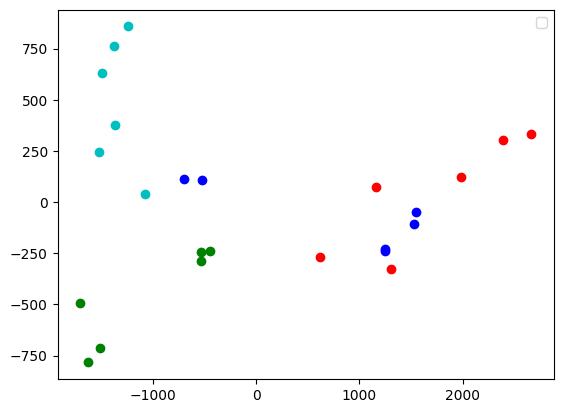

In [85]:


convolutional_network = ResNet50Gray()
model = PrototypicalNetworks(convolutional_network)
model.eval()


%run TaskSampler.ipynb

dataset = DICOMDataset(root_dir='../IMAGES/TEST_SET/', transform=None)


N_WAY = 4  # Number of classes in a task
N_SHOT = 6 # Number of images per class in the support set
N_QUERY = 1  # Number of images per class in the query set
N_EVALUATION_TASKS = 3

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
dataset.get_labels = lambda: [
    instance[1] for instance in dataset.img_labels
]

test_sampler = TaskSampler(
    dataset, n_way=N_WAY , n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    dataset,
    batch_sampler=test_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)


(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))


model.eval()
model(
    example_support_images,
    example_support_labels,
    example_query_images,
)